# 6.06 APIs for Financial Data_PartB_Analysis_Wrangling_Visuals.ipynb:

This notebook continues directly from the data-acquisition workbook (6.06 APIs for Financial Data_PartA_Data Retrieval.ipynb), where I pulled the raw series from Alpha Vantage and exported clean CSVs for use here. 

In that first notebook I saved: gdp_quarterly.csv, vti_daily.csv, vxx_daily.csv, and btc_daily.csv (BTC has ~1 year of daily history per the free tier). Those files are the single sources of truth for the analysis that follows.

In this notebook I will focus on Part 1 first. 
I’ll load the three Part-1 datasets, perform light wrangling (date typing, missing-value checks, safe de-duplication, and any minor reshaping needed to align frequencies), and then create exploratory visuals in Python to surface trends and relationships. 
Each section ends with a short, plain-English summary that records the cleaning choices and the key takeaways from the plots.


After the Python exploration for Part 1, I’ll reproduce the most informative visuals in Tableau to prepare presentation-ready charts. 
Captions in Tableau will briefly state the insight each chart is intended to show. 
I’ll then draft concise write-ups for the 6.06 Alpha Vantage data lab worksheet that explain the wrangling decisions and answer the Part-1 prompts using the best evidence from the visuals.


Once Part 1 is complete, I’ll return to this notebook to repeat the same process for Part 2 (Cryptocurrencies) using btc_daily.csv alongside VTI and VXX for context.
The notebook ends with a short summary section that links the Python findings, the Tableau visuals, and the written answers used in the final report.

## Part 1 : GDP and Consumer Sentiment During Pandemic

**0. Imports**
Put all Python imports in the cell below. If you later decide you need to import something, you must put it here and re-run!

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

--------------------
#### Part 1: Step 1 — Load CSVs, standardize, and sanity-check
---------------

In [2]:
# Files expected in the working directory:
# (1) gdp_quarterly.csv (columns: date, value)
# (2) vti_daily.csv (columns: timestamp, open, high, low, close, volume)
# (3) vxx_daily.csv (columns: timestamp, open, high, low, close, volume)
# This step only loads, parses dates/numbers, sorts, drops duplicates, and prints summaries.

# I will load the three CSVs exported from the previous notebook.
gdp_raw = pd.read_csv("gdp_quarterly.csv")
vti_raw = pd.read_csv("vti_daily.csv")
vxx_raw = pd.read_csv("vxx_daily.csv")

In [3]:
# I will copy gdp_raw to gdp for wrangling and analysis.
# I will rename the value columns of gdp_raw to "gdp" for clarity.
# Then I will convert date columns to datetime dtype, and gdp columns to numeric dtype for preparation.
# I will sort by date and drop duplicates to ensure clean time series data.
gdp = gdp_raw.copy()
gdp = gdp.rename(columns={"value": "gdp"})
gdp["date"] = pd.to_datetime(gdp["date"], errors="coerce")  # errors="coerce" to handle invalid dates by setting them to NaT
gdp["gdp"]  = pd.to_numeric(gdp["gdp"], errors="coerce")    # errors="coerce" to handle non-numeric values by setting them to NaN
gdp = (
    gdp.dropna(subset=["date"])
        .drop_duplicates(subset=["date"])     # Drop duplicate dates 
        .sort_values("date")                  # Sort by date ascending
        .reset_index(drop=True)
)


In [4]:
# I will coply vti_raw to vti for wrangling and analysis.
# I will rename the timestamp columns of vti_raw to "date" for clarity.
# Then I will convert date columns to datetime dtype, and the other 5 columns to numeric dtype for preparation.
# I will sort by date and drop duplicates to ensure clean time series data.
vti = vti_raw.copy()
vti = vti.rename(columns={"timestamp": "date"})
vti["date"] = pd.to_datetime(vti["date"], errors="coerce")
for c in ["open","high","low","close","volume"]:
    if c in vti.columns:
        vti[c] = pd.to_numeric(vti[c], errors="coerce")

vti = (
    vti.dropna(subset=["date"])
       .drop_duplicates(subset=["date"])
       .sort_values("date")
       .reset_index(drop=True)
)


# I will coply vxx_raw to vxx for wrangling and analysis.
# I will rename the timestamp columns of vxx_raw to "date" for clarity.
# Then I will convert date columns to datetime dtype, and the other 5 columns to numeric dtype for preparation.
# I will sort by date and drop duplicates to ensure clean time series data.
vxx = vxx_raw.copy()
vxx = vxx.rename(columns={"timestamp": "date"})
vxx["date"] = pd.to_datetime(vxx["date"], errors="coerce")
for c in ["open","high","low","close","volume"]:
    if c in vxx.columns:
        vxx[c] = pd.to_numeric(vxx[c], errors="coerce")

vxx = (
    vxx.dropna(subset=["date"])
       .drop_duplicates(subset=["date"])
       .sort_values("date")
       .reset_index(drop=True)
)

In [5]:
# I will define a helper function to print concise summaries of each DataFrame.
# It will show shape, date range, columns, and null counts.
# This helps verify that the data was loaded and parsed correctly.

def _summary(name, df, date_col="date"):
    print(f"\n{name} — shape: {df.shape[0]} rows x {df.shape[1]} cols")
    if date_col in df.columns and df[date_col].notna().any():
        dmin = df[date_col].min()
        dmax = df[date_col].max()
        print(f"Date range: {dmin.date()} to {dmax.date()}")
    print("Columns:", list(df.columns))
    # quick null counts
    nc = df.isna().sum()
    nz = nc[nc>0]
    if not nz.empty:
        print("Nulls present:", nz.to_dict())
    else:
        print("Nulls present: none")

print("✅ Loaded and standardized:")
_summary("GDP (quarterly)", gdp)
_summary("VTI (daily)", vti)
_summary("VXX (daily)", vxx)

✅ Loaded and standardized:

GDP (quarterly) — shape: 94 rows x 2 cols
Date range: 2002-01-01 to 2025-04-01
Columns: ['date', 'gdp']
Nulls present: none

VTI (daily) — shape: 6133 rows x 6 cols
Date range: 2001-05-31 to 2025-10-17
Columns: ['date', 'open', 'high', 'low', 'close', 'volume']
Nulls present: none

VXX (daily) — shape: 4206 rows x 6 cols
Date range: 2009-01-30 to 2025-10-17
Columns: ['date', 'open', 'high', 'low', 'close', 'volume']
Nulls present: none


In [6]:
# I will perform a sanity check to ensure expected columns are present in each DataFrame.
# If any expected columns are missing, I will print a warning message.
# This helps catch any loading or parsing issues early.
# 5 columns (Open, High, Low, Close, Volume) will be named as ohlcv for easier reference.

expected_gdp_cols = {"date","gdp"}
expected_ohlcv    = {"date","open","high","low","close","volume"}

missing_gdp = expected_gdp_cols - set(gdp.columns)
missing_vti = expected_ohlcv      - set(vti.columns)
missing_vxx = expected_ohlcv      - set(vxx.columns)

if missing_gdp: print("⚠️  GDP missing columns:", missing_gdp)
if missing_vti: print("⚠️  VTI missing columns:", missing_vti)
if missing_vxx: print("⚠️  VXX missing columns:", missing_vxx)

-----
#### Part 1: Step 2 - Build aligned close-price series for VTI & VXX and compute daily returns 
------

In [7]:
# Outputs from Part1 : Step 1 shows that all datasets have been loaded and parsed correctly, and no columns are missing.
# Therefore, I will continue to the next step to prepare analysis-ready daily series (VTI & VXX).

# In following steps, I will:
# 1) keep only the 'date' and 'close' columns for both VTI and VXX,
# 2) rename columns for clarity,
# 3) set 'date' as a proper DateTimeIndex and align on the common date range,
# 4) compute simple daily returns (pct_change) in % terms,
# 5) do tiny sanity prints (shape, date range, nulls).


# 1) keep only what I need from both VTI and VXX (date and close columns) and rename close columns for clarity
# I select close prices only because it is the most commonly used price for daily price analysis.
# Therefore, date and close columns will suffice for return calculations.

vti_s = (
    vti[["date", "close"]]
    .rename(columns={"close": "vti_close"})
    .copy()
)

vxx_s = (
    vxx[["date", "close"]]
    .rename(columns={"close": "vxx_close"})
    .copy()
)

In [8]:
# 2) I will set index to date (already datetime) and sort by index for both series
vti_s = vti_s.set_index("date").sort_index()
vxx_s = vxx_s.set_index("date").sort_index()

In [9]:
# 3) I will align on common dates by performing an inner join (inner join is safest for comparisons)
# Joining on the intersection of dates keeps the series comparable day-by-day
# This ensures that both series have data for the same dates only when analyzing returns

px = vti_s.join(vxx_s, how="inner")

In [10]:
# 4) I will compute daily returns in percent for both series (using pct_change) 
# Returns (pct change) will let me compare the performance of VTI and VXX on a daily basis even if their price levels differ significantly.
# Note: first row becomes NaN by definition as there is no prior day to compare to with pct_change
rets = px.pct_change() * 100
rets = rets.dropna()

In [11]:
# 5) I will perform sanity prints to verify the prepared DataFrames is correct and ready for analysis.

def _brief(df, name):
    print(f"\n{name}: {df.shape[0]} rows x {df.shape[1]} cols")             # this is for quick overview of size of DataFrame
    print("Date range:", df.index.min().date(), "to", df.index.max().date())  # this is to verify date coverage of the DataFrame from min to max
    print("Nulls:\n", df.isna().sum().to_dict())                             # this is to verify there are no nulls present for analysis

_brief(px,   "Aligned close prices (VTI/VXX)")    # sanity check for aligned close prices of VTI and VXX for analysis
_brief(rets, "Daily returns % (VTI/VXX)")         # sanity check for daily returns of VTI and VXX for analysis
px.head().to_string()    # preview of aligned close prices for VTI and VXX 
rets.head().to_string()  # preview of daily returns for VTI and VXX


Aligned close prices (VTI/VXX): 4206 rows x 2 cols
Date range: 2009-01-30 to 2025-10-17
Nulls:
 {'vti_close': 0, 'vxx_close': 0}

Daily returns % (VTI/VXX): 4205 rows x 2 cols
Date range: 2009-02-02 to 2025-10-17
Nulls:
 {'vti_close': 0, 'vxx_close': 0}


'            vti_close  vxx_close\ndate                            \n2009-02-02  -0.170151  -0.286944\n2009-02-03   1.411980  -4.681055\n2009-02-04  -0.527972   0.372346\n2009-02-05   1.593049  -0.611590\n2009-02-06   2.874792  -1.442550'

--------
#### Part 1 : Step 3 - Build quarterly VTI/VXX and join to GDP
--------

In [12]:
# Outputs from Part 1: Step 2 show that both aligned close prices and daily returns DataFrames are ready for analysis.
# There are no nulls present, and date ranges align correctly.

# Next, I will aggregate VTI & VXX to quarterly to compare with quarterly GDP.
# I will take the last close of each quarter as it is a common finance convention.
# Then I will join (left) onto GDP by quarter-end date for aligned, tidy analysis.


# 1) make quarterly closes from the aligned daily close frame `px`
q_px = (
    px.resample("QE").last()             # QE for quarter-end frequency; last() to get last close of each quarter 
          .rename(columns={"vti_close":"vti_q_close", "vxx_close":"vxx_q_close"})  # rename to indicate quarterly closes of VTI and VXX values for clarity
)

In [13]:
# 2) ensure GDP dates are quarter end too 
# they already look like quarter ends; but I'll be explicit by resampling with last and aligning on the index

gdp_q = (
    gdp.set_index("date")
        .resample("QE").last()[["gdp"]]  # QE for quarter-end frequency; last() to ensure quarter-end alignment
)                                       # Quarterly GDP was already quarterly; this is a safeguard for joining with q_px for analysis


In [14]:
# 3) Now, I will join quarterly market series (q_px) to quarterly GDP (gdp_q) on matching quarter-end dates
q_merged = gdp_q.join(q_px, how="left")   # left join to keep all GDP quarters, adding market data where available


In [15]:
# Install tabulate for pretty-printing DataFrames
%pip install tabulate

# 4) I will perform sanity prints to verify the merged quarterly DataFrame is correct and ready for analysis.
def _q_brief(df):
    print(f"\nQuarterly frame: {df.shape[0]} rows x {df.shape[1]} cols")
    print("Date range:", df.index.min().date(), "to", df.index.max().date())
    print("Nulls by column:\n", df.isna().sum().to_dict())

_q_brief(q_merged)
print(q_merged.head().to_markdown(index=True))

Note: you may need to restart the kernel to use updated packages.

Quarterly frame: 94 rows x 3 cols
Date range: 2002-03-31 to 2025-06-30
Nulls by column:
 {'gdp': 0, 'vti_q_close': 28, 'vxx_q_close': 28}
| date                |     gdp |   vti_q_close |   vxx_q_close |
|:--------------------|--------:|--------------:|--------------:|
| 2002-03-31 00:00:00 | 3501.12 |           nan |           nan |
| 2002-06-30 00:00:00 | 3608.5  |           nan |           nan |
| 2002-09-30 00:00:00 | 3650.25 |           nan |           nan |
| 2002-12-31 00:00:00 | 3712.84 |           nan |           nan |
| 2003-03-31 00:00:00 | 3582.77 |           nan |           nan |


-------
#### Part 1 · Step 4 — Compute quarterly Percentage changes (QoQ) for GDP, VTI, and VXX
------------------

In [16]:
# (1) I will compute Quarterly Percentage Changes (QoQ) from the merged quarterly frame `q_merged`.
#    Multiplying by 100 turns them into percentage points (e.g., 2.5%).

q_growth = (
    q_merged
      .sort_index()               # make sure quarters are in chronological order
      .pct_change()               # quarter-over-quarter % change
      .multiply(100)              # multiply by 100 to get percent
      .rename(columns={
          "gdp": "gdp_qoq_pct",          # rename columns to indicate their respective QoQ percentage changes
          "vti_q_close": "vti_qoq_pct",
          "vxx_q_close": "vxx_qoq_pct",
      })
      .dropna()                   # drop the first NaN row created by pct_change:
                                  # the first quarter has no prior quarter to compare to, so its QoQ change is undefined and dropped
)

In [17]:
# 2) Above output shows that the quarterly percentage changes have been calculated.
# Now, I will print a quick sanity summary (rows/cols, date range, nulls) and preview the data.

def _brief_q(df, name):
    print(f"\n{name}: {df.shape[0]} rows x {df.shape[1]} cols")                  # this is for quick overview of size of DataFrame 
    print("Date range:", df.index.min().date(), "to", df.index.max().date())     # this is to verify date coverage of the DataFrame from min to max
    print("Nulls by column:", df.isna().sum().to_dict())                         # this is to verify there are no nulls present for analysis

_brief_q(q_growth, "Quarterly % changes (GDP/VTI/VXX)")                          # sanity check for quarterly percentage changes of GDP, VTI, and VXX
display(q_growth.head())                                                         # preview of quarterly percentage changes for GDP, VTI, and VXX in tabular format 


Quarterly % changes (GDP/VTI/VXX): 65 rows x 3 cols
Date range: 2009-06-30 to 2025-06-30
Nulls by column: {'gdp_qoq_pct': 0, 'vti_qoq_pct': 0, 'vxx_qoq_pct': 0}


,gdp_qoq_pct,vti_qoq_pct,vxx_qoq_pct
date,,,
2009-06-30,2.101585,16.902476,-39.837470
2009-09-30,1.045960,15.820186,-26.604023
2009-12-31,2.588686,5.187535,-31.846369
2010-03-31,-3.658818,5.712258,-38.332844
2010-06-30,3.295733,-11.797281,48.500714


-----
#### Part 1 · Step 5 — Visualization with Python: Plot quarterly Percentage changes for GDP, VTI, and VXX
-----

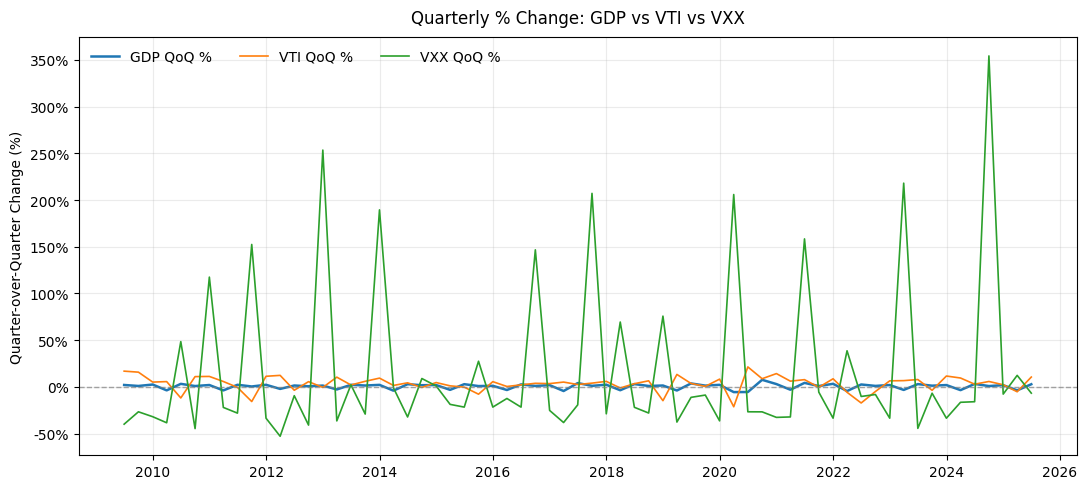

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter                   # import FuncFormatter for y-axis percentage formatting

# 1) I will make a simple line chart to compare quarterly % changes on the same axes.
#    This lets me see co-movement (or divergence) between the real economy (GDP), the broad equity market (VTI), and volatility (VXX).

fig, ax = plt.subplots(figsize=(11, 5))    # subplots with specified figure size for better visibility

ax.plot(q_growth.index, q_growth["gdp_qoq_pct"],  label="GDP QoQ %",  linewidth=1.8)
ax.plot(q_growth.index, q_growth["vti_qoq_pct"],  label="VTI QoQ %",  linewidth=1.2)
ax.plot(q_growth.index, q_growth["vxx_qoq_pct"],  label="VXX QoQ %",  linewidth=1.2)

# 2) I will add a 0% reference line to make contraction/expansion easy to see.
ax.axhline(0, color="grey", linewidth=1, linestyle="--", alpha=0.7)   
    # 0 is for 0% change reference line which helps visualize periods of growth vs contraction 
    # lindewidth=1 for visibility without overpowering the data lines
    # linestyle="--" for dashed line to distinguish from data lines
    # alpha=0.7 for slight transparency to reduce visual dominance

# 3) I will format, label, and show the chart.
ax.set_title("Quarterly % Change: GDP vs VTI vs VXX", pad=10)    #pad=10 for spacing between title and plot
ax.set_ylabel("Quarter-over-Quarter Change (%)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}%"))    
   #funcformatter to format y-axis ticks as percentages with no decimal places, 
   # lambda v, _: f"{v:.0f}%" defines the formatting function for the y-axis ticks 
ax.legend(loc="upper left", ncol=3, frameon=False)                       # legend in upper left, 3 columns, no frame for cleaner look
ax.grid(alpha=0.25)                                                      # alpha=0.25 for light grid lines to aid readability without cluttering

plt.tight_layout()                                                       #plt.tight_layout() to optimize spacing and prevent overlap
plt.show()

From the combined plot, GDP and VTI show relatively modest quarter-to-quarter swings (with a sharp shock around 2020), while VXX exhibits occasional, very large spikes that dominate the scale. To make the patterns easier to read and compare, I will split the series into small-multiple line charts (Step 6.1), and then in Step 6.2 I’ll add a simple follow-up view to highlight timing relationships and trend changes more clearly

----------
#### Part 1 · Step 6.1 — Small-multiple line charts 
--------

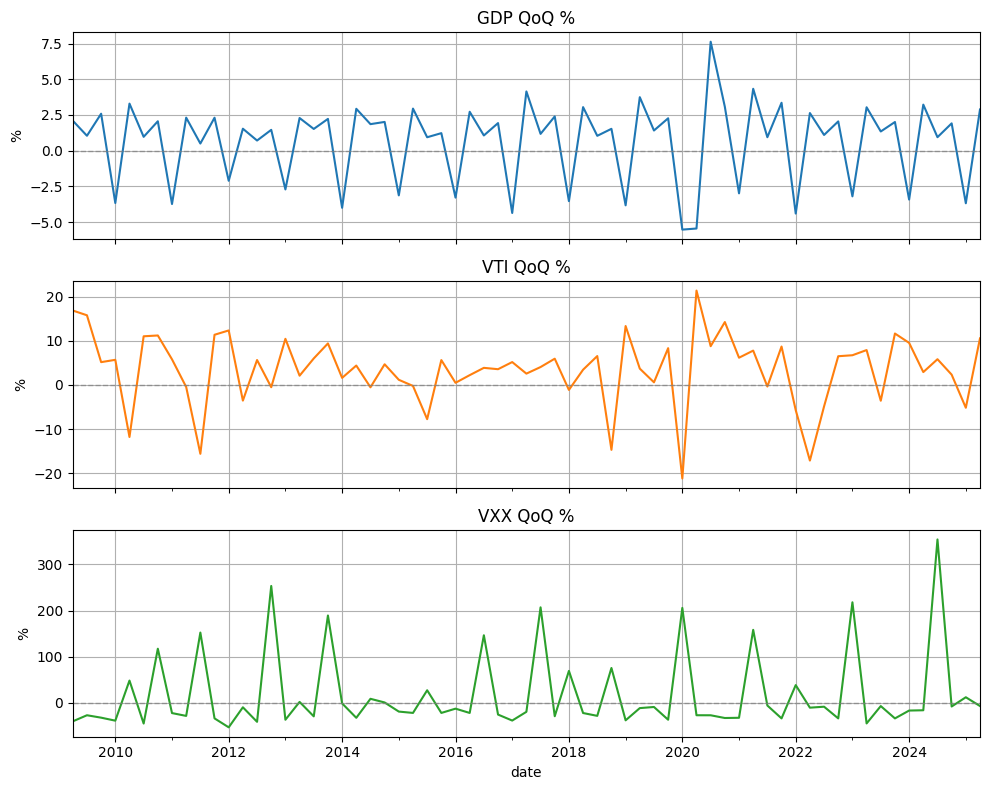

In [19]:
# I will create three simple line charts (one per series) using pandas' built-in .plot
# This keeps styling minimal and easy to read.

cols = ["gdp_qoq_pct", "vti_qoq_pct", "vxx_qoq_pct"]

ax = q_growth[cols].plot(
    subplots=True,       # one axis per series
    layout=(3, 1),       # 3 rows, 1 column
    figsize=(10, 8),     # figsize= (10, 8) for readable size 
    legend=False,        # legend not needed since each panel has a title
    grid=True            # light grid lines to aid readability without cluttering
)

# I will title each subplot and add a y-label
titles = ["GDP QoQ %", "VTI QoQ %", "VXX QoQ %"]
for a, t in zip(ax.flat, titles):
    a.set_title(t)
    a.set_ylabel("%")

# I will add a 0% reference line to each subplot for easy expansion/contraction read
for a in ax.flat:
    a.axhline(0, color="grey", linewidth=1, linestyle="--", alpha=0.7)   # consistent styling for 0% line across subplots

plt.tight_layout()                                                       #plt.tight_layout() to optimize spacing and prevent overlap
plt.show()

Looking at each series separately clarifies the different behaviors. GDP QoQ% moves in a tight band around zero with brief recessions and recoveries, including the large 2020 shock. VTI QoQ% is more volatile than GDP and shows equity-market drawdowns and rebounds that broadly line up with macro turning points. VXX QoQ% is highly spiky, with episodic volatility surges (flight-to-safety moments) that tend to jump when equities are stressed. These panels suggest timing relationships worth a closer look, so next I’ll add a simple smoothing view to highlight medium-term trend shifts.

-----------------------------
#### Part 1 · Step 6.2 — Rolling (4-quarter) averages to highlight medium-term trend shifts
--------------------

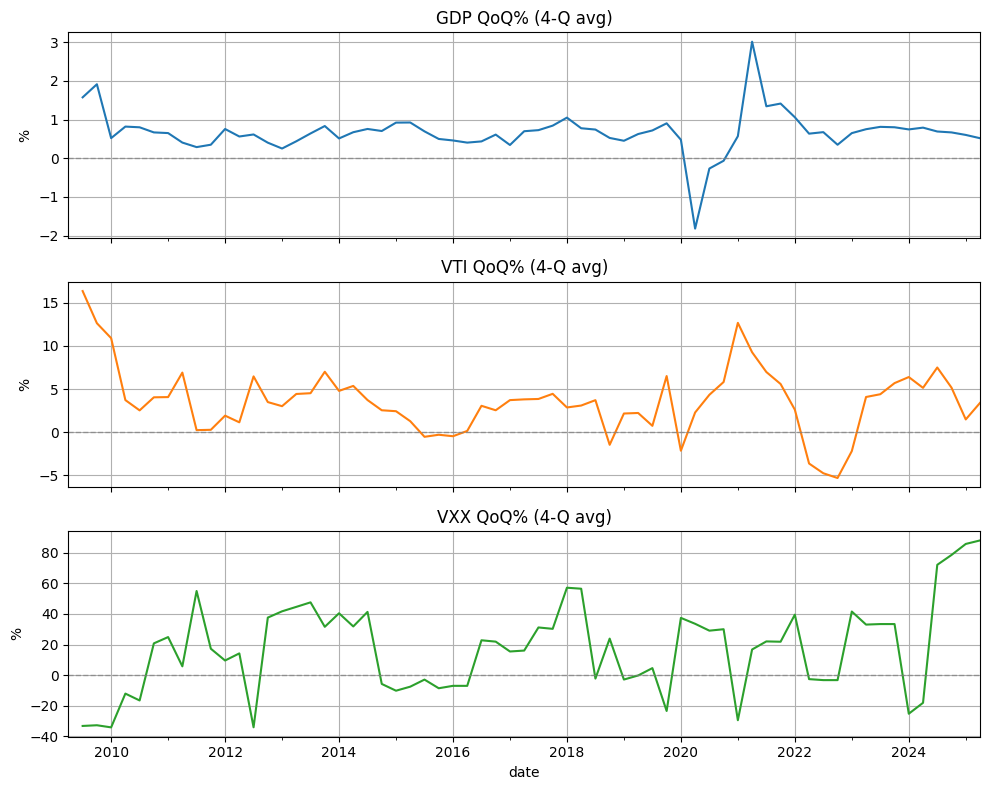

In [20]:
# I will compute a 4-quarter rolling mean for each QoQ% series to smooth short-term noise
roll = (
    q_growth[["gdp_qoq_pct", "vti_qoq_pct", "vxx_qoq_pct"]]
    .rolling(window=4, min_periods=2).mean()            
)
  # window=4 for 4-quarter rolling mean; min_periods=2 to compute mean when at least 2 data points are available
  # .mean() to calculate the average over the rolling window
  # This smooths out short-term fluctuations and highlights medium-term trends


# I will make three small charts (one per series) with consistent styling, same as Step 6.1
ax = roll.plot(
    subplots=True,           # one axis per series
    layout=(3, 1),           # 3 rows, 1 column layout for individual series
    figsize=(10, 8),         # readable size same as step 6.1
    legend=False,            # titles will serve as labels
    grid=True                # light grid for readability
)

# I will title each subplot and label the y-axis
titles = ["GDP QoQ% (4-Q avg)", "VTI QoQ% (4-Q avg)", "VXX QoQ% (4-Q avg)"]
for a, t in zip(ax.flat, titles):
    a.set_title(t)
    a.set_ylabel("%")

# I will add a 0% reference line to each subplot to make expansions/contractions easy to spot
for a in ax.flat:
    a.axhline(0, color="grey", linewidth=1, linestyle="--", alpha=0.7)
    # consistent styling for 0% line across subplots as similar to previous charts at Step 6.1

plt.tight_layout()  # this optimizes spacing to prevent overlap
plt.show()

Smoothing the QoQ series with a 4-quarter average makes the medium-term picture clearer. GDP settles into modest, positive growth for most of the period, with the pandemic drop and rebound now visible as a single deep trough followed by a sharp normalization that gradually fades toward ~0.5–1% per quarter. VTI’s 4-QE average shows multi-quarter swings that line up with broad bull-and-bear phases: weakness around 2011–2012, strength into 2017–2018, the COVID shock and recovery, and a noticeable soft patch in 2022 turning back up in 2023–2025. VXX remains structurally volatile even after smoothing; spikes cluster around market stress points (e.g., 2011, 2015–2016, 2018, 2020, 2022), reinforcing that volatility regimes tend to persist for several quarters before mean-reverting. Together, these rolling profiles suggest GDP and equities co-move broadly over multi-quarter horizons, while VXX behaves inversely and episodically—useful context for the narrative and for selecting Tableau visuals.

-----------------------------
#### Part 1 wrap-up and what’ next



That completes the Python wrangling and exploratory visuals for Part 1. I loaded and standardized GDP (quarterly) alongside VTI and VXX (daily resampled to quarterly), created aligned quarterly closes, computed QoQ changes, and inspected both raw and 4-quarter-smoothed trends. Next, I’ll reproduce a couple of presentation-ready views in Tableau using the same CSVs, adding concise captions that state the key takeaway for each chart. I will then draft short written answers for the 6.06 worksheet, summarizing the cleaning choices and the findings that address the Part-1 prompts. Once those are saved, I will return to this notebook to begin Part 2 (Cryptocurrencies), following the same pattern: light wrangling in Python, clear supporting visuals, and a brief narrative to connect results across tools.

----------------------------------------------

# Part 2: Cryptocurrencies

**0. Imports**
Put all Python imports in the cell below. If you later decide you need to import something, you must put it here and re-run!

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # for y-axis percentage formatting in case it's needed
from pathlib import Path      # for file path manipulations 


In [22]:
%pip install tabulate  # for pretty-printing DataFrames

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")   # for consistent float formatting across DataFrames
plt.rcParams["figure.figsize"] = (11, 5)                       # to set default figure size for plots
plt.rcParams["axes.grid"] = True                               # to enable grid lines on all plots by default

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


--------------------
#### Part 2: Step 1 — Load CSVs, standardize, and sanity-check
---------------

In [23]:
# Part 2, Step 1: Load, standardize, sanity-check for BTC 

# I will load the CSV file into a DataFrame with proper parsing
csv_path = Path("btc_daily.csv")   # Path is to change if file name/path differs

btc = pd.read_csv(
    csv_path,
    parse_dates=["date"],      # to ensure 'date' column is parsed as datetime while loading csv file
    dtype={
        "open": "float64",     # to ensure numeric columns of other 5 columns are loaded as float64 for precision 
        "high": "float64",
        "low": "float64",
        "close": "float64",
        "volume": "float64"
    }
)

In [24]:
# 2) I will do basic cleaning / standardization of the btc DataFrame for analysis
btc = (
    btc
    .drop_duplicates(subset=["date"])        # remove duplicate dates if any 
    .sort_values("date")
    .reset_index(drop=True)
)

In [25]:
# 3) I will perform sanity prints to verify the btc DataFrame is correct and ready for analysis.
summary = {
    "rows": len(btc),                           # to get total number of rows in btc DataFrame
    "date_min": btc["date"].min(),              # to get the earliest date in the btc DataFrame
    "date_max": btc["date"].max(),              # to get the latest date in the btc DataFrame
    "null_counts": btc.isna().sum().to_dict()   # to get null counts per column as a dictionary
}

In [26]:
# 4) I will print the summary and preview the first and last 5 rows of the btc DataFrame.
print("BTC daily file loaded.\n")          # to indicate successful loading of BTC daily data
print("Summary:") 
for k, v in summary.items(): 
    print(f"  - {k}: {v}")                 # to print each summary item in a readable format

print("\nFirst 5 rows:")                   # for previewing the first 5 rows of the btc DataFrame 
display(btc.head())

print("\nLast 5 rows:")                    # for previewing the last 5 rows of the btc DataFrame
display(btc.tail())

BTC daily file loaded.

Summary:
  - rows: 350
  - date_min: 2024-11-04 00:00:00
  - date_max: 2025-10-19 00:00:00
  - null_counts: {'date': 0, 'open': 0, 'high': 0, 'low': 0, 'close': 0, 'volume': 0, 'market_cap_usd': 350}

First 5 rows:


,date,open,high,low,close,volume,market_cap_usd
0,2024-11-04,"68,736.4000","69,453.9400","66,783.7700","67,807.4800","12,431.0137",NaN
1,2024-11-05,"67,810.1500","70,557.6700","67,427.5300","69,380.7300","12,867.6613",NaN
2,2024-11-06,"69,380.6400","76,509.5600","69,285.8200","75,646.5500","45,398.1184",NaN
3,2024-11-07,"75,646.5500","76,999.0000","74,463.9600","75,920.0000","21,932.4021",NaN
4,2024-11-08,"75,925.0000","77,312.1800","75,654.2600","76,566.7300","18,378.3988",NaN



Last 5 rows:


,date,open,high,low,close,volume,market_cap_usd
345,2025-10-15,"113,072.1800","113,671.9900","110,185.8700","110,804.1200","7,440.0378",NaN
346,2025-10-16,"110,804.1100","112,021.0700","107,464.5300","108,198.0000","14,792.7875",NaN
347,2025-10-17,"108,197.9900","109,269.9700","103,516.7500","106,463.3000","13,824.3446",NaN
348,2025-10-18,"106,462.0900","107,535.6800","106,357.6900","107,208.9100","3,552.6096",NaN
349,2025-10-19,"107,208.9100","107,300.0000","107,000.0000","107,035.9100",107.0572,NaN


In [27]:
# 5) I will drop the 'market_cap_usd' column because it is entirely NaN in this file

if "market_cap_usd" in btc.columns:
    btc = btc.drop(columns=["market_cap_usd"])

# I will re-run a quick summary to confirm the change
summary = {
    "rows": len(btc),                     # total rows after dropping market_cap_usd
    "date_min": btc["date"].min(),        # earliest date check
    "date_max": btc["date"].max(),        # latest date check
    "null_counts": btc.isna().sum().to_dict(),   # nulls per column check
}

In [28]:
# I will print the updated summary and preview the first and last 5 rows of the btc DataFrame.

print("BTC daily file (after dropping market_cap_usd).\n")  # to indicate successful dropping of market_cap_usd column
print("Summary:")
for k, v in summary.items():
    print(f" - {k}: {v}")          # to print each summary item in a readable format 

print("\nFirst 5 rows:")
display(btc.head())                # for previewing the first 5 rows of the btc DataFrame

print("\nLast 5 rows:")
display(btc.tail())                # for previewing the last 5 rows of the btc DataFrame

BTC daily file (after dropping market_cap_usd).

Summary:
 - rows: 350
 - date_min: 2024-11-04 00:00:00
 - date_max: 2025-10-19 00:00:00
 - null_counts: {'date': 0, 'open': 0, 'high': 0, 'low': 0, 'close': 0, 'volume': 0}

First 5 rows:


,date,open,high,low,close,volume
0,2024-11-04,"68,736.4000","69,453.9400","66,783.7700","67,807.4800","12,431.0137"
1,2024-11-05,"67,810.1500","70,557.6700","67,427.5300","69,380.7300","12,867.6613"
2,2024-11-06,"69,380.6400","76,509.5600","69,285.8200","75,646.5500","45,398.1184"
3,2024-11-07,"75,646.5500","76,999.0000","74,463.9600","75,920.0000","21,932.4021"
4,2024-11-08,"75,925.0000","77,312.1800","75,654.2600","76,566.7300","18,378.3988"



Last 5 rows:


,date,open,high,low,close,volume
345,2025-10-15,"113,072.1800","113,671.9900","110,185.8700","110,804.1200","7,440.0378"
346,2025-10-16,"110,804.1100","112,021.0700","107,464.5300","108,198.0000","14,792.7875"
347,2025-10-17,"108,197.9900","109,269.9700","103,516.7500","106,463.3000","13,824.3446"
348,2025-10-18,"106,462.0900","107,535.6800","106,357.6900","107,208.9100","3,552.6096"
349,2025-10-19,"107,208.9100","107,300.0000","107,000.0000","107,035.9100",107.0572


------------
#### Part 2 — Step 2: Standardize BTC and Add Helper Columns for Analysis 
------------------------

In [ ]:
# Part 2 — Step 2: I will standardize BTC and add helper columns for analysis

# I will start from the btc DataFrame that I already loaded and cleaned in Step 1.
btc2 = (
    btc.copy()
      .drop(columns=["market_cap_usd"], errors="ignore")  # drop empty column if present
      .dropna(subset=["date"])                            # keep only rows with a valid date
      .drop_duplicates(subset=["date"])                   # deduplicate by date (if any)
      .sort_values("date")                                # sort in time order
      .reset_index(drop=True)                             # reset index after sorting
)


In [30]:
# I will compute daily close-to-close return in percent for btc2 for further analysis.
btc2["daily_return_pct"] = btc2["close"].pct_change() * 100

In [31]:
# I will create a month key to use for monthly summaries later for btc 2 for further analysis. 
btc2["month"] = btc2["date"].dt.to_period("M")

In [32]:
# I will index the close price so the first close starts at 100 for easier comparison over time.
first_close = btc2["close"].iloc[0]                              # iloc[0] to get the first close price to use as the base for indexing
btc2["close_index_100"] = (btc2["close"] / first_close) * 100    
    # calculate indexed close price starting at 100 by dividing each close by the first close and multiplying by 100

In [33]:
# I will perform a quick sanity print to verify the btc2 DataFrame is ready for analysis.

print("Rows:", len(btc2))                                                             # to print total number of rows in btc2 DataFrame
print("Date range:", btc2["date"].min().date(), "to", btc2["date"].max().date())      # to print date range of btc2 DataFrame
display(btc2.head())                                                                  # to preview the first 5 rows of btc2 DataFrame

Rows: 350
Date range: 2024-11-04 to 2025-10-19


,date,open,high,low,close,volume,daily_return_pct,month,close_index_100
0,2024-11-04,"68,736.4000","69,453.9400","66,783.7700","67,807.4800","12,431.0137",NaN,2024-11,100.0000
1,2024-11-05,"67,810.1500","70,557.6700","67,427.5300","69,380.7300","12,867.6613",2.3202,2024-11,102.3202
2,2024-11-06,"69,380.6400","76,509.5600","69,285.8200","75,646.5500","45,398.1184",9.0311,2024-11,111.5608
3,2024-11-07,"75,646.5500","76,999.0000","74,463.9600","75,920.0000","21,932.4021",0.3615,2024-11,111.9640
4,2024-11-08,"75,925.0000","77,312.1800","75,654.2600","76,566.7300","18,378.3988",0.8519,2024-11,112.9178


----

#### Part 2 , Step 3 : Plotting Charts in Python for BTC 
Part 2, Step 3.1 : Chart 1 (Python): BTC Indexed Close (100 = first close)

-----

NOTE ON INDEXING:
The chart will show an *index*, not USD price.


I will set the first close to 100 and scale the rest as : index_t = (close_t / first_close) * 100


Example: if first_close=$67,807 and latest_close=$107,036, latest index ≈ (107,036 / 67,807)*100 ≈ 157.9  → +57.9% vs start.

---------

In [ ]:
# Part 2, Step 3 : Quick summary of BTC performance over the dataset period before plotting chart
# 0) I will print a summary line showing the start and end close prices, index value at the end, and total % change over the period for btc2.
# This will give a quick overview of BTC's performance over the dataset period before deeper analysis.

start_close = btc2["close"].iloc[0]                    # iloc[0] to get the first close price for starting point
end_close   = btc2["close"].iloc[-1]                   # iloc[-1] to get the last close price for ending point
idx_end     = (end_close / start_close) * 100          # calculate index value at the end based on starting close price
chg_pct     = (end_close / start_close - 1) * 100      # calculate total percentage change from start to end
print(
    f"Start close: ${start_close:,.0f} | Last close: ${end_close:,.0f} "
    f"| Index last: {idx_end:.1f} | Change vs start: {chg_pct:.1f}%"
)

Start close: $67,807 | Last close: $107,036 | Index last: 157.9 | Change vs start: 57.9%


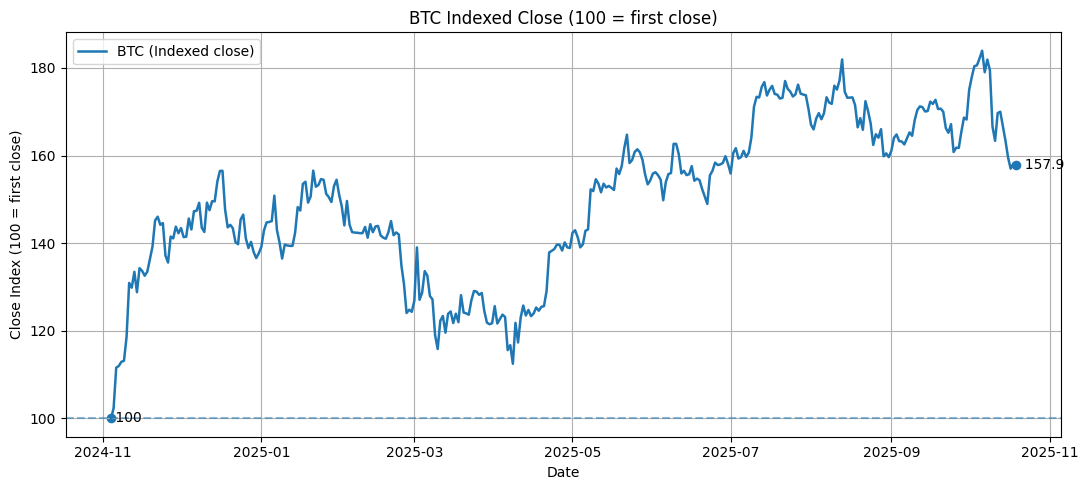

In [36]:
# Part 2 , Step 3: I will plot BTC indexed close over time (100 = first close) as above summary shows significant growth
# This chart will visualize BTC's price growth over time, indexed to 100 at the start for easier comparison.

fig, ax = plt.subplots()

# 1) line of indexed close
ax.plot(btc2["date"], btc2["close_index_100"], label="BTC (Indexed close)", linewidth=1.8)  
  # plot indexed close over time with label and line width for visibility

# 2) add a horizontal line at 100 for reference  
ax.axhline(100, linestyle="--", alpha=0.5)   #alpha=0.5 for slight transparency to reduce visual dominance

# 3) mark the start and end points with scatter and text annotations for clarity
start = btc2.iloc[0]
end   = btc2.iloc[-1]
ax.scatter([start["date"], end["date"]], 
           [start["close_index_100"], end["close_index_100"]], 
           s=35)

ax.text(start["date"], start["close_index_100"], " 100", va="center")                          # annotate start point with text showing initial indexed close value
ax.text(end["date"], end["close_index_100"], f"  {end['close_index_100']:.1f}", va="center")   # annotate end point with text showing final indexed close value

# 4) add labels, title, legend, and format the plot
ax.set_title("BTC Indexed Close (100 = first close)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Index (100 = first close)")
ax.legend(loc="upper left")                                       # legend in upper left for clarity
plt.tight_layout()                                                #plt.tight_layout() to optimize spacing and prevent overlap
plt.show()

BTC Indexed Close (100 = first close) chart: This chart tracks Bitcoin’s relative performance by setting the first close to 100. The final value of ~158 means BTC finished about +58% above the starting point for this period. The path was choppy—there was a sharp dip in March 2025, a strong rally into late summer, and a pullback into October. Because it’s indexed, the chart shows growth/decline in percentage terms rather than dollar price, which makes it easier to compare with other assets later.

-------
#### Part 2, Step 3.2 - Chart 2 (Python): BTC daily return % distribution
-----------------

To answer what happened to BTC in the last few years from a risk angle, I will plot a histogram of daily returns to visualize how often BTC has small/normal moves vs large/extreme moves. This will gives quick statistical insight into BTC's volatility and risk profile over the dataset period

In [37]:
# Part 2, Step 3.2 : BTC Daily Return % Distribution (Histogram)

# Firstly, I will make a tidy copy, drop the first NaN return, and cap the x-axis
# so outliers do not dominate the view (you can tweak 'x_min'/'x_max').

ret = btc2[["date", "daily_return_pct"]].dropna().copy()

In [38]:
# I will do a quick statistical summary of daily returns for context before plotting the histogram.

mean_ret = ret["daily_return_pct"].mean()          # compute mean of daily returns
std_ret  = ret["daily_return_pct"].std()           # compute standard deviation of daily returns
n_days   = len(ret)                                # compute total number of days in the returns DataFrame 
tails_lt = (ret["daily_return_pct"] < -10).sum()   # count of days with daily return less than -10%
tails_gt = (ret["daily_return_pct"] >  10).sum()   # count of days with daily return greater than 10%

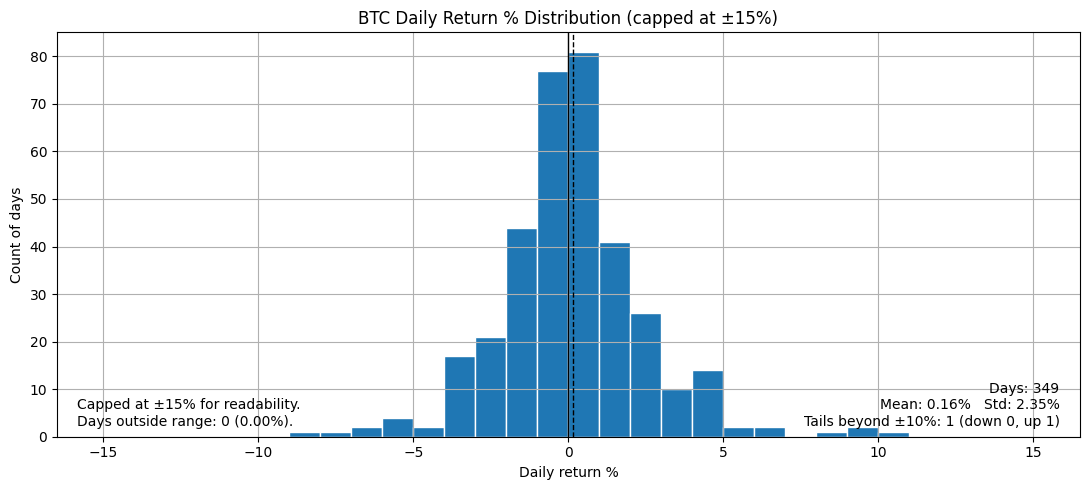

In [41]:
# I will choose a practical plotting window and bins (1% steps) for the histogram.

x_min, x_max = -15, 15         # show between -15% and +15%
bins = list(range(x_min, x_max + 1))  # 1% bins to cover the range 

fig, ax = plt.subplots()     # create figure and axis for plotting

# I will plot the histogram of daily returns with specified range and bins.
ax.hist(
    ret["daily_return_pct"],        # data to plot
    range=(x_min, x_max),          # x-axis limits, capped at ±15% for visibility
    bins=bins,                     # bins defined above (1% steps)
    edgecolor="white"              # white edges for better visual separation of bars
)

# I will add vertical lines for mean and 0% reference for context.
ax.axvline(0, color="black", linewidth=1)                         # 0% reference line for context
ax.axvline(mean_ret, color="black", linestyle="--", linewidth=1)  # mean return line for context, dashed for distinction

# I will quantify how many days fall outside the displayed window (±15%) for context.
tails_15 = (ret["daily_return_pct"].abs() > 15).sum()   # count days with absolute return greater than 15%
tails_15_pct = 100 * tails_15 / len(ret)   

# I will annotate this info on the chart after plotting for context.
cap_note = f"Capped at ±15% for readability.\nDays outside range: {tails_15} ({tails_15_pct:.2f}%)."
ax.text(0.02, 0.02, cap_note, transform=ax.transAxes, ha="left", va="bottom")         # calculate percentage of days outside ±15% range

# I will format the plot with title, labels, and annotate key stats.
ax.set_title("BTC Daily Return % Distribution (capped at ±15%)")   
ax.set_xlabel("Daily return %")
ax.set_ylabel("Count of days")

# I will annotate key stats in the lower right for quick reading. 
txt = (
    f"Days: {n_days}\n"                                    # total days of data
    f"Mean: {mean_ret:.2f}%   Std: {std_ret:.2f}%\n"       # mean and standard deviation of daily returns
    f"Tails beyond ±10%: {tails_lt + tails_gt} "           # total count of extreme daily returns
    f"(down {tails_lt}, up {tails_gt})"                    # breakdown of extreme daily returns
)
ax.text(
    0.98, 0.02, txt, transform=ax.transAxes,             # positioning in axes coordinates (bottom right)
    ha="right", va="bottom"                              # right-aligned horizontally, bottom-aligned vertically
)

plt.tight_layout()                                    #plt.tight_layout() to optimize spacing and prevent overlap
plt.show()

Why cap the histogram at ±15%?


I cap the x-axis at ±15% to keep the chart readable. A few very large daily moves can stretch the scale and make the normal cluster of days look tiny. With BTC’s daily volatility around ~2.35%, a ±15% window is roughly ±6 standard deviations which is well beyond typical moves, so we still capture almost all meaningful days while avoiding a long, empty axis. I am not deleting data; I am only limiting the view. I also show how many days sit outside ±15% so it’s clear what’s hidden.

From the above BTC daily return % distribution (capped at ±15% ) chart which is for ~ lat 350 days : Most days are small moves around zero. The average day is +0.16%, with a typical swing (std dev) of ~2.35%. The bulk of days fall within ±3%, and we only saw one “large” day beyond ±10% (an up day) in this window. The shape is slightly right-skewed—there are a few more positive outliers than negative ones—which fits the rally you saw in the indexed-price chart. Bottom line: over this period, BTC showed day-to-day volatility a few percent wide, with rare but meaningful tail moves that investors should still respect.

------------------
### Part 2 Wrap-up and What's next 


This completes the Python prep and quick visuals for Part 2: Cryptocurrencies. I loaded and standardized the BTC daily file, created an indexed-price view (100 = first close) to show relative growth, and plotted a daily-return histogram (capped at ±15%) to summarize typical risk and tail days. Next, I will switch to Tableau to compare BTC vs VTI vs VXX on the same scale—starting with an Indexed Close (100 = first close) view (required) and, if time allows, a Monthly Return % view. After the Tableau charts are finalized, I will compile a short written summary and attach the two most informative charts for stakeholders.

-----------



